<a href="https://colab.research.google.com/github/JonasMiksch/Research_Project_SimCLR/blob/main/Classifier_SimCLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Standard libraries
import os
from copy import deepcopy

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## tqdm for loading bars
from tqdm.notebook import tqdm
#from torchvision.datasets import STL10
## PyTorch
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
from math import sqrt, ceil, floor
from statistics import mean

from torchvision.io import read_image
from random import randint

from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
from torchvision.utils import make_grid
from torch.nn import functional as F
import torch

try:
    import wandb
except ModuleNotFoundError: 
    !pip3 install wandb
    import wandb

try:
    import torchinfo
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip3 install torchinfo
    import torchinfo

## Torchvision
import torchvision
from torchvision import transforms
from torchvision import models
import numpy as np
# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip3 install --quiet pytorch-lightning>=1.4 # type : ignore
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
import pandas as pd
import pdb
from torch.utils.data import DataLoader,Dataset
# Import tensorboard
%reload_ext tensorboard


# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

     |████████████████████████████████| 1.7 MB 11.0 MB/s 
     |████████████████████████████████| 181 kB 46.1 MB/s 
     |████████████████████████████████| 144 kB 58.8 MB/s 
     |████████████████████████████████| 63 kB 492 kB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=d060aeeb018ba46a1ee0ae8c2b1cc35f9ab71f5a00731d6e5a619b1ede3faad2
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


Global seed set to 42


Device: cuda:0


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
!unzip gdrive/My\ Drive/Seminararbeit/JPEGImages.zip > /dev/null
#




Mounted at /content/gdrive


In [ ]:
#Dataset_Paths TODO Change these accordingly
WORKING_DIRECTORY = '/content/gdrive/My Drive/Seminararbeit'
ARTDL_CSV_PATH = WORKING_DIRECTORY
img_folder = 'JPEGImages'

#ADD name of checkpoint 
modeltype = "SimClR"
filename = os.path.join(modeltype+"Classifier_Test")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH =  os.path.join(WORKING_DIRECTORY,"checkpoints")


In [ ]:
class ImageDataset(Dataset):
  def __init__(self,csv,img_folder,transform):
    self.csv=csv
    self.transform=transform
    self.img_folder=img_folder
    
    self.image_names=self.csv[:]['item']
    self.labels=np.array(self.csv.drop(['item', 'set', 'artdl_label'], axis=1))

  def __len__(self):
    return len(self.image_names)

  
  def __getitem__(self,index):
    img_path = os.path.join(self.img_folder, self.image_names.iloc[index]+'.jpg')
    image = read_image(img_path)
    image = self.transform(image)
    return image,self.labels[index]

In [ ]:
img_transforms = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize((256,256)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,),
                                                      )])

train_data = pd.read_csv(os.path.join(WORKING_DIRECTORY,'artdl_train.csv'))
test_data = pd.read_csv(os.path.join(WORKING_DIRECTORY,'artdl_test.csv'))
val_data = pd.read_csv(os.path.join(WORKING_DIRECTORY,'artdl_valid.csv'))

train_data_class=ImageDataset(train_data,img_folder,img_transforms)
val_data_class=ImageDataset(val_data,img_folder,img_transforms)
test_data_class=ImageDataset(test_data,img_folder,img_transforms)

Global seed set to 42


torch.Size([6, 3, 256, 256])


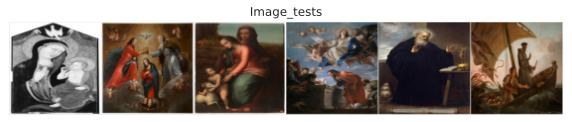

In [ ]:
pl.seed_everything(42)
NUM_IMAGES = 6
imgs = torch.stack([train_data_class[idx][0] for idx in range(NUM_IMAGES) ], dim=0)
print(imgs.shape)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)
plt.figure(figsize=(10,5))
plt.title('Image_tests')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [ ]:
class SimCLR(pl.LightningModule):

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=50):
        super().__init__()
        self.save_hyperparameters('hidden_dim','lr','temperature','weight_decay',"max_epochs")
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        # Base model f(.)
        self.convnet = torchvision.models.resnet50(pretrained=False,
                                                   num_classes=4*hidden_dim)  # Output of last linear layer
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode='train'):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)

        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        #self.log(mode+'_loss', nll)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)],
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        #wandb.log({mode+' accuracy_top1': (sim_argsort == 0).float().mean(),
                   #mode+' accuracy_top5': (sim_argsort <5).float().mean(),
                   #mode+ ' loss': nll})
        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')

In [ ]:
simclr_model = SimCLR.load_from_checkpoint(checkpoint_path=os.path.join(CHECKPOINT_PATH,modeltype))

In [ ]:
@torch.no_grad()
def prepare_data_features(model, dataset):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)
    # Encode all images
    data_loader = data.DataLoader(dataset, batch_size=64, num_workers=NUM_WORKERS, shuffle=False, drop_last=False)
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(data_loader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        batch_feats = batch_feats.detach().cpu()
        #print(batch_feats[:3])
        feats.append(batch_feats)
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    #print(feats[0][:2])
    #print(feats[1][:2])
    #print(feats[2][:2])
    #print(feats.shape)
    # Sort images by labels
    #labels, idxs = labels.sort()
    #feats = feats[idxs]

    return data.TensorDataset(feats, labels)

In [ ]:
print(modeltype)
train_feats_simclr = prepare_data_features(simclr_model, train_data_class)
val_feats_simclr = prepare_data_features(simclr_model, val_data_class)
test_feats_simclr = prepare_data_features(simclr_model, test_data_class)
print(type(train_feats_simclr))

SimClR


  0%|          | 0/236 [00:00<?, ?it/s]

tensor([0.9154, 1.1322])
tensor([1.4965, 0.6414])
tensor([0.9462, 0.5089])
torch.Size([15073, 2048])


  0%|          | 0/30 [00:00<?, ?it/s]

tensor([1.2272, 0.2718])
tensor([1.6000, 0.2689])
tensor([1.3755, 0.8120])
torch.Size([1861, 2048])


  0%|          | 0/30 [00:00<?, ?it/s]

tensor([1.5736, 0.4112])
tensor([1.4814, 0.2686])
tensor([0.8217, 1.3283])
torch.Size([1864, 2048])
<class 'torch.utils.data.dataset.TensorDataset'>


In [ ]:

y = np.concatenate([y for x, y in val_feats_simclr], axis=0)
x = np.concatenate([x for x, y in val_feats_simclr], axis=0)
#z = np.concatenate([x for x, y in train_feats_simclr], axis=0)
print(x.shape)
# same = True
# for i in range(x.shape[0]):
#     if np.array_equal(x[i],first) == False:
#       same = False
# if same == True:
#   print("Features are all the same")

# same_label = True
# first_label = y[0]
# for j in range(y.shape[0]):
#     if np.array_equal(y[j],first_label) == False:
#       same_label = False
# if same_label == True:
#   print("Labels are all the same")

print(train_feats_simclr.tensors[1].shape)

def flatten(original_dataset):
     new_dataset = data.TensorDataset(
         original_dataset.tensors[0],original_dataset.tensors[1].flatten(0,1)
     )
     return new_dataset

train_feats_simclr2 = flatten(train_feats_simclr)
val_feats_simclr2 = flatten(val_feats_simclr)
test_feats_simclr2 = flatten(test_feats_simclr)
print(train_feats_simclr2.tensors[1].shape)

(3811328,)
torch.Size([15073, 1])
torch.Size([15073])


In [ ]:
print(train_feats_simclr2.tensors[0].shape)
print(train_feats_simclr2.tensors[1].shape)

label = np.concatenate([y for x, y in train_feats_simclr2], axis=0)
feats = np.concatenate([x for x, y in train_feats_simclr2], axis=0)

print(label.shape)
print(feats.shape)

print(label[0])
print(label[2])

print(feats[0,:3])

print(feats[5,:3])

AssertionError: ignored

In [ ]:
class LogisticRegression(pl.LightningModule):

    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        # Mapping from representation h to classes
        self.model = nn.Linear(feature_dim, num_classes)


    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(),
                                lr=self.hparams.lr,
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                                      milestones=[int(self.hparams.max_epochs*0.6),
                                                                  int(self.hparams.max_epochs*0.8)],
                                                      gamma=0.1)
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode='train'):
        feats, labels = batch
        preds = self.model(feats)

        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        wandb.log({mode + '_acc': acc, mode + '_loss': loss})
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode='train')

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode='val')

    def test_step(self, batch, batch_idx):
        feats, labels = batch
        preds = self.model(feats)

        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()
        wandb.log({'test' + '_acc': acc, 'test' + '_loss': loss})
        x =  {'test_loss': loss, 'test_acc': acc}
        self.log_dict(x)
        return x

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()

        avg_acc = torch.stack([x['test_acc'].float() for x in outputs]).mean()

        logs = {'test_loss': avg_loss, 'test_acc': avg_acc}
        
        return {'avg_test_loss': avg_loss, 'avg_test_acc': avg_acc, 'log': logs, 'progress_bar': logs}

In [ ]:
def train_logreg(resume, batch_size, train_feats_data, val_feats_data,test_feats_data, max_epochs, **kwargs):
    train_loader = data.DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                                   drop_last=False, pin_memory=True, num_workers=0)
    val_loader = data.DataLoader(val_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)
    test_loader = data.DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                                  drop_last=False, pin_memory=True, num_workers=0)
    pl.seed_everything(42)  # To be reproducable
    if os.path.exists(os.path.join(CHECKPOINT_PATH,filename))and resume == False:
      trainer = pl.Trainer(gpus=1 if str(device)=='cuda:0' else 0,
                         max_epochs=max_epochs,
                         progress_bar_refresh_rate=1)
      print("dont_train")
      model = LogisticRegression.load_from_checkpoint(checkpoint_path=os.path.join(CHECKPOINT_PATH,filename))

    elif os.path.exists(os.path.join(CHECKPOINT_PATH,filename))and resume:
      wandb.init(project=filename,resume="allow",id = filename)
      print("resume_training")


      trainer = pl.Trainer(gpus=1 if str(device)=='cuda:0' else 0,
                            max_epochs=max_epochs,
                            progress_bar_refresh_rate=1)
        
      model = LogisticRegression.load_from_checkpoint(checkpoint_path=os.path.join(CHECKPOINT_PATH,filename))
      trainer.fit(model, train_loader, val_loader, ckpt_path=os.path.join(CHECKPOINT_PATH,filename))
      trainer.save_checkpoint(os.path.join(CHECKPOINT_PATH,filename))
    else:
      print("start_training")
      wandb.init(project=filename,resume="allow",id = filename)
      trainer = pl.Trainer(gpus=1 if str(device)=='cuda:0' else 0,
                         max_epochs=max_epochs,
                         progress_bar_refresh_rate=1)
      model = LogisticRegression(**kwargs)
      trainer.fit(model, train_loader, val_loader)
      trainer.save_checkpoint(os.path.join(CHECKPOINT_PATH,filename))

    results = trainer.test(model, test_dataloaders=test_loader, verbose=False)
    return model,results

In [ ]:
x = 0.08
originalfilename = filename
for i in range(1):
    x = x*3
    filename = originalfilename+str(x)
    print(str(x))
    resnet_model,test_result = train_logreg(resume = True,
                                        batch_size=64,
                                        train_feats_data=train_feats_simclr2,
                                        val_feats_data=val_feats_simclr2,
                                        test_feats_data = test_feats_simclr2,
                                        feature_dim=train_feats_simclr.tensors[0].shape[1],
                                        num_classes=10,
                                        lr=x,
                                        weight_decay=1e-3,
                                        max_epochs = 150
                                        )

print(test_result)

Global seed set to 42


0.24
start_training


test_acc,▃▅▇▇▇▇▇█▅▇▅▆█▆▆▇▇█▇▇▇▆▇▆▆▅▅▃▂▁
test_loss,█▃▂▂▁▁▂▂▃▁▃▂▁▂▂▃▂▂▂▂▂▂▂▄▃▅▄▄▆▇
train_acc,▄▅▁▄▇▄▄▆▃▄█▅▄▅▄▅▅▆▆▆▆▆▆▆▆▇▅▆▆▇▆▅▆▇█▇▇▇▆▆
train_loss,▄▇▆▄█▇▆█▆▇▃█▅▆▆▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▂▇▄▁▇▃▄▂▄▂▄▂▅▅▆▆▆▄▆▄▄▆▆▆▂▅▅█▅▆▆▇▇▅▆▆▅▁▆
val_loss,▇▃▅▃▇▄▃▄█▃▄▃▆█▆▄▁▁▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁
test_acc,0.125
test_loss,4.50803
train_acc,0.60606
train_loss,1.86975
val_acc,0.4


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | model | Linear | 20.5 K
---------------------------------
20.5 K    Trainable params
0         Non-trainable params
20.5 K    Total params
0.082     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
Exception ignored in: <function tqdm.__del__ at 0x7f3c1a5e94d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/usr/local/lib/python3.7/dist-packages/tqdm/notebook.py", line 291, in close
    self.disp(close=True, check_delay=False)
AttributeError: 'Tqdm' object has no attribute 'disp'
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:907: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[{'test_loss': 79.42649841308594, 'test_acc': 0.5300429463386536}]
